# 🤗 Multimodal generation - Part 4: non-linear mapping using an autoencoder 🤗

In [1]:
cd ..

/Users/simonbrandeis/dev/multimodal-code-exercise


## Approach

Let's now tackle the improvement points highlighted in the `3_simple_linear_model` notebook.

We want to learn a representation mapping that is:
- non-linear
- trained end-to-end

We'll implement an auto-encoder with the following architecture:

![Auto-encoder architecture schema](../assets/auto_encoder_schema.png "Proposed architecture")

Where the encoder and decoder part are feed-forward neural networks with one hidden layer.

We have two objectives here:
- learn a representation that is close to an ImageNet embedding ("mapping" task)
- learn a representation that conserves the information contained in the sentence embedding ("reconstruction" task)

We can learn them simultaneously by computing a criterion (for example, the Mean Squared Error) for both tasks and use a weighted sum of both criterions as the loss function to optimize:

$$ \text{loss} = \alpha_{reconstruction} * \text{loss}_{reconstruction} + \alpha_{mapping} * \text{loss}_{mapping} $$

# Implementation

In [2]:
import os
import numpy as np
import torch
import transformers
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModel
from pytorch_pretrained_biggan import BigGAN

## Parameter definition

In [3]:
DATA_DIR="./data/"
MODELS_DIR="./models/"
PRETRAINED_LM_NAME = 'distilbert-base-uncased'
PRETRAINED_GAN_NAME = 'biggan-deep-128'
SEED=42

## Load the data

In [4]:
labels_tensor = torch.load(os.path.join(DATA_DIR, "labels_tensor.bin"))
labels_representations_tensor = torch.load(os.path.join(DATA_DIR, "labels_representations_tensor.bin"))
text_representations_tensor = torch.load(os.path.join(DATA_DIR, "text_representations_tensor.bin"))

## Prepare the data for learning

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [6]:
dataset = TensorDataset(
    text_representations_tensor,
    labels_representations_tensor,
)

In [7]:
numpy_rng = np.random.RandomState(SEED)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=numpy_rng, stratify=labels_tensor.detach().numpy())

# Learn

## Parameters definition - architecture

In [8]:
_, _, source_dim = text_representations_tensor.shape
_, target_dim = labels_representations_tensor.shape

hidden_dim = 1024  # Hidden dimension of the two-layer perceptrons
p_dropoout = 0.15  # Dropout probability for the two-layer perceptrons

## Parameter definition - optimization

In [9]:
batch_size = 32
initial_lr = 0.01
max_epochs_per_fit = 15
n_fits = 2
early_stopping_patience = 1

## Data loaders

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

## Model instanciation

In [11]:
from text2img.models.auto_encoder import TwoLayerPerceptron, AutoEncoder
from text2img.models.utils import BertSimplePooler, SqueezeLayer

In [12]:
pooler = nn.Sequential(BertSimplePooler(), SqueezeLayer())

In [13]:
encoder = TwoLayerPerceptron(in_features=source_dim, out_features=target_dim,
                             hidden_dim=hidden_dim, dropout_probability=p_dropoout)

decoder = TwoLayerPerceptron(in_features=target_dim, out_features=source_dim,
                             hidden_dim=hidden_dim, dropout_probability=p_dropoout)

auto_encoder = AutoEncoder(encoder, decoder)

In [14]:
model_to_train = nn.Sequential(pooler, auto_encoder)

In [15]:
print(model_to_train)

Sequential(
  (0): Sequential(
    (0): BertSimplePooler()
    (1): SqueezeLayer()
  )
  (1): AutoEncoder(
    (encoder): TwoLayerPerceptron(
      (hidden_layer): Linear(in_features=768, out_features=1024, bias=True)
      (hidden_activation): Tanh()
      (dropout): Dropout(p=0.15, inplace=False)
      (output_layer): Linear(in_features=1024, out_features=128, bias=True)
    )
    (decoder): TwoLayerPerceptron(
      (hidden_layer): Linear(in_features=128, out_features=1024, bias=True)
      (hidden_activation): Tanh()
      (dropout): Dropout(p=0.15, inplace=False)
      (output_layer): Linear(in_features=1024, out_features=768, bias=True)
    )
  )
)


## Loss and criterion instanciation

In [16]:
optimizer_class = torch.optim.Adam

In [17]:
from torch.nn import MSELoss
from text2img.optimization import BiObjectiveLoss

reconstruction_loss = MSELoss()
mapping_loss = MSELoss()

reconstruction_weight = .5
mapping_weight = 1.

multi_objective_loss = BiObjectiveLoss(
    criterion_1=mapping_loss, criterion_2=reconstruction_loss,
    weight_1=mapping_weight, weight_2=reconstruction_weight,
)

## Learning the parameters via gradient descent

In [18]:
history = {
    "train_loss": [],
    "train_loss_reconstruction": [],
    "train_loss_mapping": [],

    "val_loss": [],
    "val_loss_reconstruction": [],
    "val_loss_mapping": [],

    "fit_nb": [],
    "best_model": None,
    "best_val_loss": None
}

learning_rate = initial_lr

for fit_nb in range(n_fits):
    print(f"--------- FIT #{fit_nb + 1} ---------")
    if fit_nb > 0:
        learning_rate /= 10  # Reduce learning rates after first fit

    # Load best model so far, if it exists
    if history["best_model"] is not None:
        best_model_state = history["best_model"]
        model_to_train.load_state_dict(best_model_state)

    epoch = 0
    stop_training = False
    optimizer = optimizer_class(model_to_train.parameters(), lr=learning_rate)
    did_not_improve_count = 0

    while not stop_training and epoch < max_epochs_per_fit:
        epoch += 1
        print(f"> [FIT #{fit_nb + 1}][EPOCH #{epoch}][LR = {learning_rate}]")

        ## Train on all batches
        model_to_train.train()

        # Init batch-wise history
        train_loss = []
        train_loss_reconstruction = []
        train_loss_mapping = []

        # Iterate over batches
        for train_batch in train_dataloader:
            lm_hidden_state, gan_hidden_state = train_batch
            optimizer.zero_grad()
            encoded, decoded = model_to_train(lm_hidden_state)
            decoded_true = pooler(lm_hidden_state)
            loss_on_batch = multi_objective_loss(
                inputs=(encoded, decoded),
                targets=(gan_hidden_state, decoded_true),
            )
            loss_on_batch.backward()
            optimizer.step()
            train_loss.append(loss_on_batch.item())

            # Reconstruction and mapping loss - for visualization purpose only
            with torch.no_grad():
                train_loss_reconstruction.append(reconstruction_loss(decoded, decoded_true).item())
                train_loss_mapping.append(mapping_loss(encoded, gan_hidden_state).item())
        
        # Compile batch-wise losses
        train_loss_epoch = sum(train_loss) / len(train_loss)
        history["train_loss_mapping"].append(sum(train_loss_mapping) / len(train_loss_mapping))
        history["train_loss_reconstruction"].append(sum(train_loss_reconstruction) / len(train_loss_reconstruction))
        print(f"Train loss:         {train_loss_epoch:.4f}")

        ## Compute the loss on the validation set
        model_to_train.eval()

        # Init batch-wise history
        val_loss = []
        val_loss_reconstruction = []
        val_loss_mapping = []

        # Iterate over batches
        for val_batch in val_dataloader:
            lm_hidden_state, gan_hidden_state = val_batch
            with torch.no_grad():
                encoded, decoded = model_to_train(lm_hidden_state)
                decoded_true = pooler(lm_hidden_state)
                val_loss.append(multi_objective_loss(
                                    inputs=(encoded, decoded),
                                    targets=(gan_hidden_state, decoded_true),
                                ).item())
                val_loss_reconstruction.append(reconstruction_loss(decoded, decoded_true).item())
                val_loss_mapping.append(mapping_loss(encoded, gan_hidden_state).item())
        val_loss_epoch = sum(val_loss) / len(val_loss)
        history["val_loss_mapping"].append(sum(val_loss_mapping) / len(val_loss_mapping))
        history["val_loss_reconstruction"].append(sum(val_loss_reconstruction) / len(val_loss_reconstruction))
        print(f"Validation loss:    {val_loss_epoch:.4f}")

        # Save best model state
        best_val_loss = history["best_val_loss"] or np.inf
        if val_loss_epoch < best_val_loss:
            history["best_model"] = model_to_train.state_dict()
            history["best_val_loss"] = val_loss_epoch
            did_not_improve_count = 0

        # Early stopping: stop training if val loss did not improve since last 3 epochs
        if history["best_val_loss"] and val_loss_epoch > history["best_val_loss"]:
            did_not_improve_count += 1
            if did_not_improve_count > early_stopping_patience:
                print(f"Stop fit - validation loss dod not improve in last {early_stopping_patience} epochs")
                stop_training = True

        # Append losses to history
        history["val_loss"].append(val_loss_epoch)
        history["train_loss"].append(train_loss_epoch)
        print()

model_to_train.load_state_dict(history["best_model"])
print("End of training")


--------- FIT #1 ---------
> [FIT #1][EPOCH #1][LR = 0.01]
Train loss:         8.5316
Validation loss:    0.0450

> [FIT #1][EPOCH #2][LR = 0.01]
Train loss:         0.2662
Validation loss:    0.0415

> [FIT #1][EPOCH #3][LR = 0.01]
Train loss:         0.2132
Validation loss:    0.0532

> [FIT #1][EPOCH #4][LR = 0.01]
Train loss:         0.1690
Validation loss:    0.0324

> [FIT #1][EPOCH #5][LR = 0.01]
Train loss:         0.1249
Validation loss:    0.0346

> [FIT #1][EPOCH #6][LR = 0.01]
Train loss:         0.0972
Validation loss:    0.0354
Stop fit - validation loss dod not improve in last 1 epochs

--------- FIT #2 ---------
> [FIT #2][EPOCH #1][LR = 0.001]
Train loss:         0.0966
Validation loss:    0.0281

> [FIT #2][EPOCH #2][LR = 0.001]
Train loss:         0.0570
Validation loss:    0.0228

> [FIT #2][EPOCH #3][LR = 0.001]
Train loss:         0.0453
Validation loss:    0.0243

> [FIT #2][EPOCH #4][LR = 0.001]
Train loss:         0.0359
Validation loss:    0.0228

> [FIT #2][E

## Visualising the training process

The following script allows us to check the evolution of the losses along the epochs

/Users/simonbrandeis/dev/multimodal-code-exercise/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


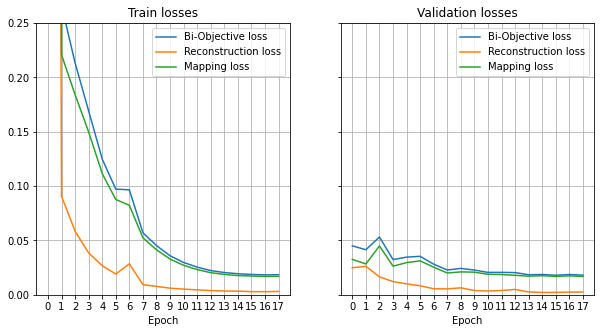

In [19]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))

ax1.plot(history["train_loss"], label="Bi-Objective loss")
ax1.plot(history["train_loss_reconstruction"], label="Reconstruction loss")
ax1.plot(history["train_loss_mapping"], label="Mapping loss")
ax1.set_title("Train losses")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid()

ax2.plot(history["val_loss"], label="Bi-Objective loss")
ax2.plot(history["val_loss_reconstruction"], label="Reconstruction loss")
ax2.plot(history["val_loss_mapping"], label="Mapping loss")
ax2.set_title("Validation losses")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()

plt.ylim((0, 0.25))
plt.xticks(range(len(history["train_loss"])))
fig.show()

In [20]:
torch.save(model_to_train, os.path.join(MODELS_DIR, "auto_encoder.pth"))

# Demonstration

## Load the pretrained language models and GAN

In [26]:
lm_model = AutoModel.from_pretrained(PRETRAINED_LM_NAME)
lm_tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_LM_NAME)
gan_model = BigGAN.from_pretrained(PRETRAINED_GAN_NAME)

## Use the mapping model we've just trained ...

In [22]:
mapping_model = nn.Sequential(
    pooler,
    model_to_train[1].encoder
)

## ... Or load a pretrained one

In [25]:
trained_autoencoder = torch.load(os.path.join(MODELS_DIR, "auto_encoder_tuned.pth"))
pooler = trained_autoencoder[0]
trained_encoder = trained_autoencoder[1].encoder
mapping_model = nn.Sequential(pooler, trained_encoder)

## Evaluation on arbitrary input

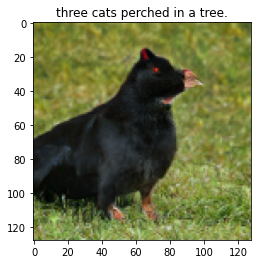

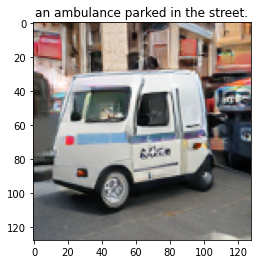

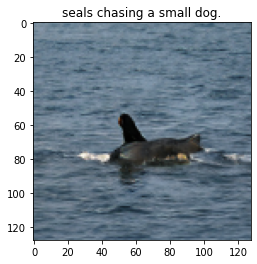

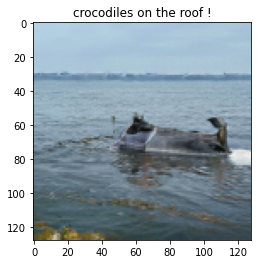

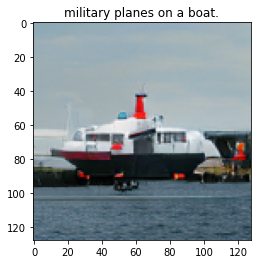

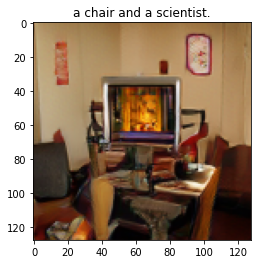

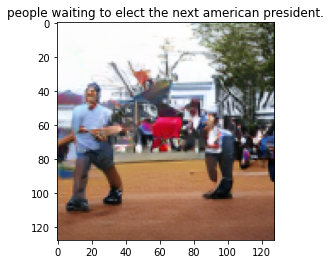

In [27]:
from run_model import generate_image, print_image, text_to_image

INPUT_TEXT = [
    "three cats perched in a tree.",
    "an ambulance parked in the street.",
    "seals chasing a small dog.",
    "crocodiles on the roof !",
    "military planes on a boat.",
    "a chair and a scientist.",
    "people waiting to elect the next american president."
]

mapping_model.eval()

for sentence in INPUT_TEXT:
    text_to_image(
        text=sentence,
        lm_model=lm_model,
        lm_tokenizer=lm_tokenizer,
        gan_model=gan_model,
        mapping_model=mapping_model,
    )

# Discussion

The generated images look much more like real images: we can see trees, buildings, what seems to be human and animal silhouettes. That's an improvement !